In [1]:
# import libraries
import pandas as pd
import numpy as np
import nltk
import re
import logging
import time 
import matplotlib.pyplot as plt
import string
from PIL import Image
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from gensim.models import word2vec
from sklearn.cluster import KMeans 
from wordcloud import WordCloud, STOPWORDS
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.corpus import wordnet
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load Data and Data Proprocessing

In [2]:
# load data
train = pd.read_csv("../data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("../data/testData.tsv", header=0, delimiter="\t", quoting=3)
df_train1=pd.read_csv("../data/imdb_master.csv",encoding="latin-1")

#To ensure sufficient data set, mix all 50,000 pieces of data in label and test set.

test.insert(1, 'sentiment', 0)
for i in range(len(test)):
    if int(re.sub("[^0-9]", " ", test["id"][i].split("_")[1])) <= 5:
        test['sentiment']=0
    elif int(re.sub("[^0-9]", " ", test["id"][i].split("_")[1])) > 5:
        test['sentiment']=1


# Divided into train set and test set according to 8: 2
test_set,train_set=train_test_split(test,test_size=0.2,random_state=1)
train_set=train.append(train_set)

#Processing the imported external data, eliminating irrelevant and unsupervised items and unifying the format.
df_train1=df_train1.drop(["type",'file'],axis=1)
df_train1.rename(columns={'label':'sentiment',
                          'Unnamed: 0':'id',
                          'review':'review'}, 
                 inplace=True)               
df_train1 = df_train1[df_train1.sentiment != 'unsup']
maping = {'pos': 1, 'neg': 0}
df_train1['sentiment'] = df_train1['sentiment'].map(maping)
train_set=pd.concat([train_set,df_train1])

train_set=train_set.reset_index(drop=True)
test_set=test_set.reset_index(drop=True)

In [3]:
train_set.shape

(75000, 3)

## Word vectorization

In [5]:
#Introducing word2vec tool
import gensim

review_lines = list()
lines = train_set['review'].values.tolist()
#Generate a format that can be used for word2vec input
for line in lines:

    tokens = word_tokenize(line)   
    
     #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    review_lines.append(words)
    
#Set reasonable embedding vector dimensions.   
embedding_vector_size = 150
model_1 = gensim.models.Word2Vec(sentences = review_lines, vector_size=embedding_vector_size, min_count=1, window=5, workers=4 )
words = list(model_1.wv.index_to_key)
print("vocab size:", len(words)) # to get total number of unique words

vocab size: 134276


In [6]:
#Select the number of most commonly used words.Contains word tokens extracted from lines
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)        
train_test_data = review_lines                       
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)

In [7]:
# Preparing embedding matrix
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))

#Constructing embedded vector matrix
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
#Data cleaning function
def review_to_words( raw_review ):
    
    #Use the BeautifulSoup library to get rid of the original text and remove symbols such as < br/>.
    review_text = BeautifulSoup(raw_review).get_text() 
    
    #Remove non-letters with regular expression
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    #Convert to lower case, split into individual words
    words = letters_only.lower().split()                           
    
    #Create set of stopwords and remove stop words
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    
    #return the result.
    return( " ".join( meaningful_words ))   

train_set['review']=train_set['review'].apply(review_to_words)
test_set["review"]=test_set["review"].apply(review_to_words)

## Word Visualization

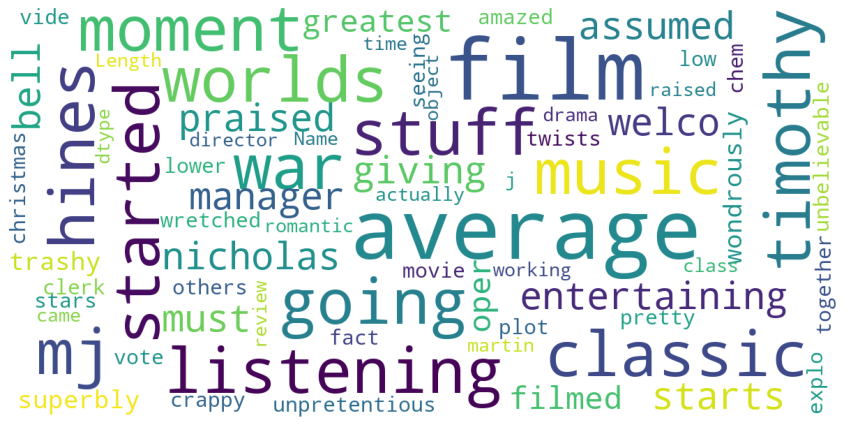

In [9]:
#Drawing of cloud pictures
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train_set["review"])

In [10]:
#Convert a document into a separate sentence.
list_classes = ["sentiment"]
y = train_set[list_classes].values
list_sentences_train = train_set["review"]
list_sentences_test = test_set["review"]

In [11]:
#With the mapping relation dict between words and numbers corresponding to texts_to_sequences
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)


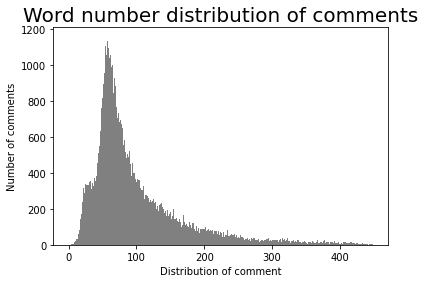

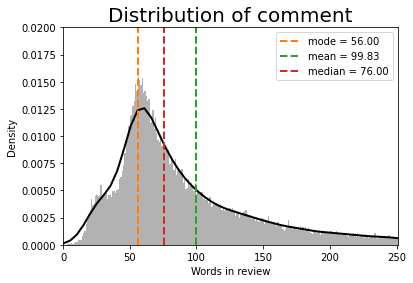

In [12]:
#Generate pictures of word number and document distribution.
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,450,1),color='grey')
plt.xlabel("Distribution of comment")
plt.ylabel("Number of comments")
plt.title("Word number distribution of comments",fontsize=20)
plt.show()

#Calculate the average value of scientific documents and other parameters.
train_set['review_lenght'] = [len(one_comment) for one_comment in list_tokenized_train]
median = train_set['review_lenght'].median()
mean = train_set['review_lenght'].mean()
mode = train_set['review_lenght'].mode()[0]

fig, ax = plt.subplots()
sns.distplot(train_set['review_lenght'], bins=train_set['review_lenght'].max(),
            hist_kws={"alpha": 0.6, "color": "grey"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 2})
ax.set_xlim(left=0, right=np.percentile(train_set['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.02
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=2)
ax.set_title('Distribution of comment', fontsize=20)
plt.legend()
plt.show()

In [13]:
#Fill the sequence to the same length. Short ones are filled when available, and long ones are intercepted.
maxlen = 400
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [14]:
vocab_size = embedding_matrix.shape[0]
vocab_size

134277

## Build Model

In [15]:
#Modeling and training
import tensorflow as tf
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation,Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D,MaxPool1D,GRU
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

INIT_LR = 0.00015
embed_size = 150
batch_size = 64
epochs = 30

#Build a model，use keras function,and compile
model = Sequential()
model.add(Input(shape=(maxlen, )))
model.add(Embedding(vocab_size, embed_size, weights = [embedding_matrix]))
model.add(Dropout(0.15))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(GRU(100))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
                  metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1,min_lr=0.01*INIT_LR)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 150)          20141550  
_________________________________________________________________
dropout (Dropout)            (None, 400, 150)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 32)           14432     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 32)           0         
_________________________________________________________________
gru (GRU)                    (None, 100)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [16]:
#Write a call termination class, and stop training when the accuracy exceeds the threshold.
class CustomCallback(callbacks.Callback):
    def __init__(self, accuracy=0.98):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>=self.accuracy):
            print(f"\nReached {self.accuracy} accuracy so cancelling training!")
            self.model.stop_training = True

callbacks=CustomCallback()

In [17]:
#fit model
#reduce the learning rate when the val_loss doesn't decrease
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1,min_lr=0.01*INIT_LR)
history=model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.4,callbacks=[callbacks,reduce_lr])

Epoch 1/30
704/704 [==============================] - 25s 29ms/step - loss: 0.6231 - accuracy: 0.6378 - val_loss: 0.4835 - val_accuracy: 0.7725
Epoch 2/30
704/704 [==============================] - 19s 27ms/step - loss: 0.4644 - accuracy: 0.7818 - val_loss: 0.4046 - val_accuracy: 0.8183
Epoch 3/30
704/704 [==============================] - 19s 27ms/step - loss: 0.4041 - accuracy: 0.8168 - val_loss: 0.3570 - val_accuracy: 0.8444
Epoch 4/30
704/704 [==============================] - 20s 28ms/step - loss: 0.3637 - accuracy: 0.8408 - val_loss: 0.3199 - val_accuracy: 0.8667
Epoch 5/30
704/704 [==============================] - 20s 28ms/step - loss: 0.3347 - accuracy: 0.8577 - val_loss: 0.2960 - val_accuracy: 0.8769
Epoch 6/30
704/704 [==============================] - 19s 27ms/step - loss: 0.3122 - accuracy: 0.8678 - val_loss: 0.2795 - val_accuracy: 0.8830
Epoch 7/30
704/704 [==============================] - 19s 27ms/step - loss: 0.2929 - accuracy: 0.8782 - val_loss: 0.2620 - val_accuracy:

KeyboardInterrupt: 

Results and visualization

In [ ]:
#plot the curse and result
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Lose')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Get the predicted value and convert the result to True OR False.
prediction = model.predict(X_te)
prediction2 = model.predict(X_t)
y_pred = (prediction > 0.5) 
y_train_pred = (prediction2 > 0.5)

In [ ]:
test_set["sentiment"] = test_set["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = test_set["sentiment"]

In [ ]:
y_pred.shape

## Result Part

In [ ]:
#Calculation accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
#Calculate f1 score and confusion matrix
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

In [ ]:
#Draw confusion matrix picture
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    
    ax.set_title(title, y=1.0, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.2, fontsize=14)
    ax.set_yticklabels(class_names, rotation=0)
sns.set(rc = {'figure.figsize':(11,13)})  
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(train_set["sentiment"], y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

In [ ]:
#plot the curse and result
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    #plt.legend([metric, 'val_'+metric])
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(test_acc, test_loss)